In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import sys, os, time
import numpy as np
import mujoco_py as mjp
from foundation import util
import cv2

#import dm_control as dmc

import matplotlib.pyplot as plt

from domain_randomization_mujoco import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from dm_control import suite
from dm_control import viewer

In [9]:
# Load an environment from the Control Suite.
env = suite.load(domain_name="humanoid", task_name="stand")

# Launch the viewer application.
viewer.launch(env)

In [3]:
tasks = suite.ALL_TASKS
len(tasks)

41

In [4]:
task = tasks[5]

In [5]:
env = suite.load(*task)

In [6]:
env.reset()

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('position', array([-0.00614489, -0.99995661,  0.00931544])), ('velocity', array([-0.00982888, -0.00616084]))]))

In [7]:
viewer.launch?

In [14]:
viewer.launch(env)

KeyboardInterrupt: 

In [12]:
env = suite.load(domain_name="humanoid", task_name="stand")
action_spec = env.action_spec()

# Define a uniform random policy.
def random_policy(time_step):
    del time_step  # Unused.
    return np.random.uniform(low=action_spec.minimum,
                           high=action_spec.maximum,
                           size=action_spec.shape)

# Launch the viewer application.
viewer.launch(env, policy=random_policy)

In [17]:
tmpl_path = '../foundation/envs/assets/multi_object_template.xml'
tex_path = '/home/fleeb/Downloads/dtd/images/'
bg_path = '/home/fleeb/Downloads/val_256/'

In [18]:
texture_files = util.crawl(tex_path, lambda x: '.jpg' in x)
bg_files = util.crawl(bg_path, lambda x: '.png' in x)
len(texture_files), len(bg_files)

(5640, 36500)

In [19]:
tpath = np.random.choice(texture_files)
bpath = np.random.choice(bg_files)

In [20]:
bpath

'/home/fleeb/Downloads/val_256/Places365_val_00019873.png'

<IPython.core.display.Javascript object>


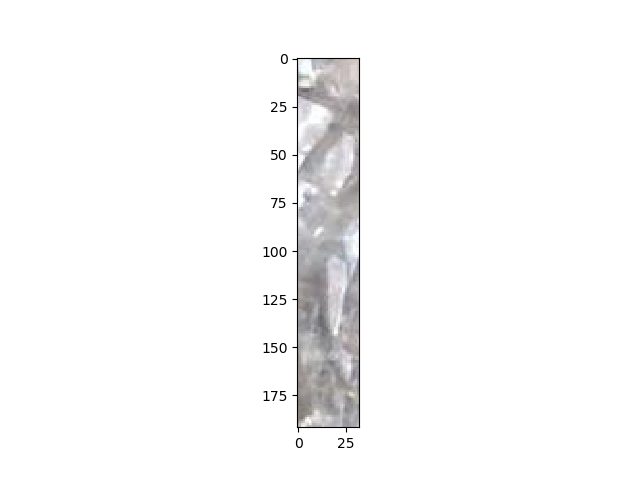

((192, 32, 3), dtype('uint8'))

In [21]:
p = get_patch(tpath, 32*6, 32)
plt.figure()
plt.imshow(p)
p.shape, p.dtype

<IPython.core.display.Javascript object>


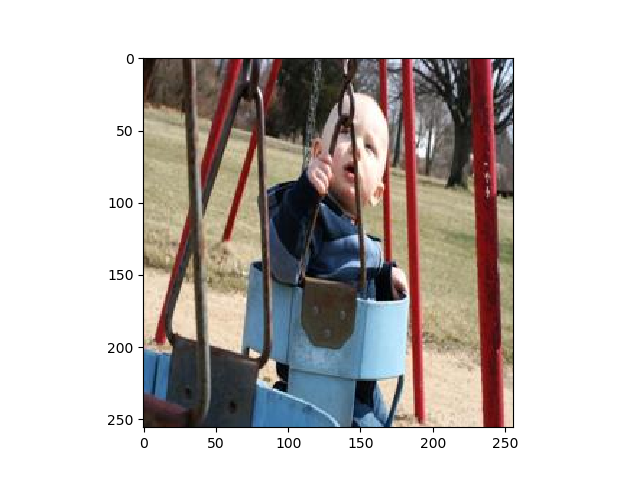

(256, 256, 3)

In [22]:
p2 = get_img(bpath, 256)
plt.figure()
plt.imshow(p2)
p2.shape

In [24]:
with open(tmpl_path, 'r') as f:
    model_tmpl = f.read()

num_prim = 3

In [25]:
attrs = gen_object(num_prim)
names = ['geom', 'material', 'texture']

geoms, materials, textures = [[xml_format(name, a) for a in attr] for attr, name in zip(attrs, names)]
textures = [xml_format('texture', gen_skybox(bg_files))] + textures
assets = materials + textures

model_str = model_tmpl.format('\n\t\t\t'.join(assets), '\n\t\t\t'.join(geoms))

In [26]:
model = mjp.load_model_from_xml(model_str)
sim = mjp.MjSim(model)

In [27]:
sim.reset()

In [28]:
sim.model.body_geomadr

array([-1, -1,  0,  3], dtype=int32)

In [29]:
sim.model.tex_type

array([2, 1, 1, 1, 1], dtype=int32)

In [34]:
sim.model.mat_rgba

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)

In [32]:
sim.model.geom_matid

array([ 0,  1,  2, -1, -1], dtype=int32)

In [35]:
sim.model.geom_bodyid

array([2, 2, 2, 3, 3], dtype=int32)

In [ ]:
sim.model.body_name2id

In [38]:
np.isclose(np.array([10,100.3, 100.001]), 100.)

array([False, False,  True])

In [33]:
sim.model.geom_rgba

array([[0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0.5, 0.5, 0.5, 1. ],
       [0. , 0. , 1. , 0.5],
       [0. , 0. , 1. , 0.5]], dtype=float32)

In [31]:
state = sim.get_state()
state

MjSimState(time=0.0, qpos=array([0., 0., 0., 0., 0., 0.]), qvel=array([0., 0., 0., 0., 0., 0.]), act=None, udd_state={})

In [32]:
sim.model.geom_names

('obj_box', 'geom0', 'geom1', 'geom2')

In [33]:
w, h = sim.model.tex_width, sim.model.tex_height
print(w, h)

[256  32  32  32  32] [256 192 192 192 192]


In [35]:
#data = sim.model.tex_rgb.reshape(len(w), h[0], w[0], -1)
#data.shape

ValueError: cannot reshape array of size 270336 into shape (5,256,256,newaxis)

In [68]:
tex = pick_textures(sim, texture_files, bg_files, bg_idx=0)
texture_geoms(sim, tex)

(256, 256, 3)

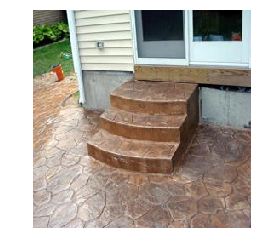

In [69]:
idx = 0

s = sim.model.tex_adr[idx]
e = sim.model.tex_adr[idx+1] if (idx+1) < len(sim.model.tex_adr) else len(sim.model.tex_rgb)
h,w = sim.model.tex_height[idx], sim.model.tex_width[idx]
data = sim.model.tex_rgb[s:e].reshape(h,w,3)
plt.figure()
plt.imshow(data)
plt.axis('off')
data.shape

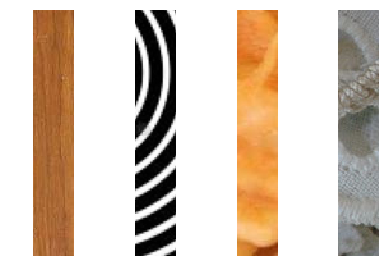

In [70]:
fig, axes = plt.subplots(1, len(sim.model.tex_adr)-1)
for i,ax in enumerate(axes.flat):
    idx = i+1
    plt.sca(ax)

    s = sim.model.tex_adr[idx]
    e = sim.model.tex_adr[idx+1] if (idx+1) < len(sim.model.tex_adr) else len(sim.model.tex_rgb)
    h,w = sim.model.tex_height[idx], sim.model.tex_width[idx]
    data = sim.model.tex_rgb[s:e].reshape(h,w,3)
    
    plt.axis('off')
    plt.imshow(data)
    #data.shape
fig.tight_layout()

In [37]:
sim.model.tex_type

array([2, 1, 1, 1, 1], dtype=int32)

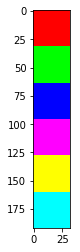

In [38]:
plt.figure()
plt.imshow(data[0])

In [73]:
sim.model.light_active

array([1], dtype=uint8)

In [74]:
sim.model.camera_names

('external_camera_0',)

In [100]:
campos = np.array([[2.2, 0, 0]])
dist = 3
fovy = 45*np.pi/180
fovx = fovy#*4/3
corners = np.array([[-dist, dist*np.tan(fovx/2), dist*np.tan(fovy/2)],
                    [-dist, dist*np.tan(fovx/2), -dist*np.tan(fovy/2)],
                    [-dist, -dist*np.tan(fovx/2), -dist*np.tan(fovy/2)],
                    [-dist, -dist*np.tan(fovx/2), dist*np.tan(fovy/2)],
                    
                    [-dist, dist*np.tan(fovx/2), dist*np.tan(fovy/2)],
                   ])
corners += campos

In [101]:
h, w, d = np.array([1, 1, 1.]) / 2

boxpos = np.array([[0,0,0.]])

boxcorners = np.array([[h, w, d],
                       [h, w, -d],
                       [h, -w, -d],
                       [h, -w, d],
                       
                       [-h, -w, d],
                       [-h, -w, -d],
                       [-h, w, -d],
                       [-h, w, d],
                       
                       [h, w, d],
                      ])
boxcorners += boxpos

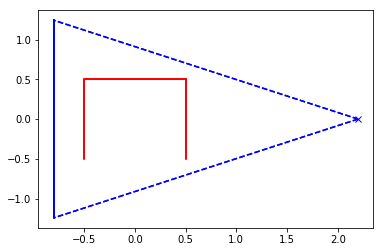

In [104]:
sel = [0,2]
plt.figure()
plt.plot(*campos[:,sel].T, ls='', marker='x', color='b')
plt.plot(*corners[:,sel].T, ls='-', color='b')
plt.plot(*boxcorners[:,sel].T, ls='-', color='r')
cx, cy = campos[0,sel]
for c in corners[:-1]:
    x, y = c[sel]
    plt.plot([cx, x], [cy, y], ls='--', color='b')

In [106]:
print(campos)
print(dist)
print(h,w,d)
print(boxpos)

[[2.2 0.  0. ]]
3
0.5 0.5 0.5
[[0. 0. 0.]]


In [107]:
sim.model.geom_type

array([6, 4, 4, 5], dtype=int32)

In [108]:
sim.render?

In [109]:
cv2.imwrite?

In [118]:
img = np.random.rand(450, 450, 3)*0

In [119]:
cv2.imwrite('noise.png', img)

True

In [120]:
sim.model.cam_pos

array([[1.8, 0. , 0.9]])

In [123]:
sim.model.geom_size

array([[0.5   , 0.5   , 0.2   ],
       [0.0767, 0.1414, 0.1392],
       [0.08  , 0.0698, 0.1463],
       [0.1176, 0.0565, 0.1083]])

In [124]:
sim.model.body_geomnum

array([1, 0, 3, 0], dtype=int32)

In [125]:
sim.model.body_geomadr

array([ 0, -1,  1, -1], dtype=int32)

In [129]:
sim.model.geom_bodyid, sim.model.body_names

(array([0, 2, 2, 2], dtype=int32),
 ('world', 'floor0', 'floating_obj', 'external_camera_body_0'))

In [131]:
sim.model.geom_pos

array([[ 0.    ,  0.    ,  0.    ],
       [ 0.066 , -0.0393, -0.0324],
       [ 0.0046, -0.0232,  0.032 ],
       [ 0.0278,  0.0255,  0.0201]])

In [132]:
sim.model.geom_quat

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [-0.83593207,  0.03218965, -0.54720462, -0.02735881],
       [-0.74354574, -0.53307095, -0.36807889, -0.16581021],
       [-0.73611318, -0.19433972, -0.48817671,  0.42667664]])

In [133]:
sim.model.body_inertia

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.00821539, 0.00705783, 0.00586623],
       [0.        , 0.        , 0.        ]])

In [134]:
sim.model.mat_

array([-1,  0,  1,  2], dtype=int32)

In [96]:
def lnorm(v, axis=0, p=2, keepdims=False):
    v = np.abs(v)**p
    n = v.sum(axis=axis, keepdims=keepdims)
    return n ** (1/p)

In [46]:
g = np.mgrid[-2:2:1000j,-2:2:1000j]
g.shape

(2, 1000, 1000)

In [55]:
norm = 1/lnorm(g, p=-0.1)

<IPython.core.display.Javascript object>


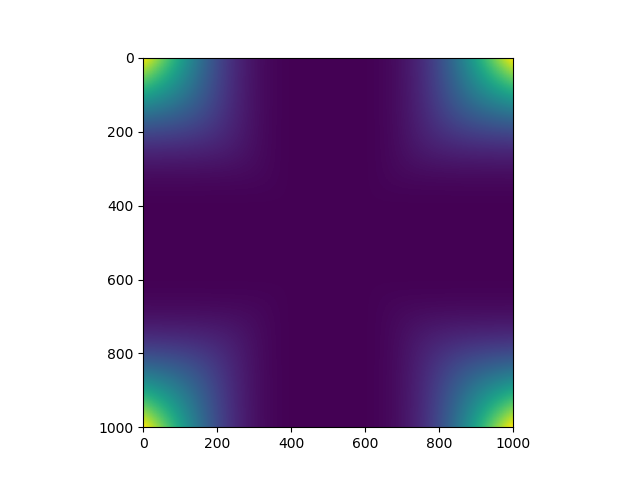

In [120]:
p = -4
norm = lnorm(g, p=p)**np.abs(p)
plt.figure()
plt.imshow(norm)
#plt.plot(x.reshape(-1),y.reshape(-1), ls='', marker='.')
pass

<IPython.core.display.Javascript object>


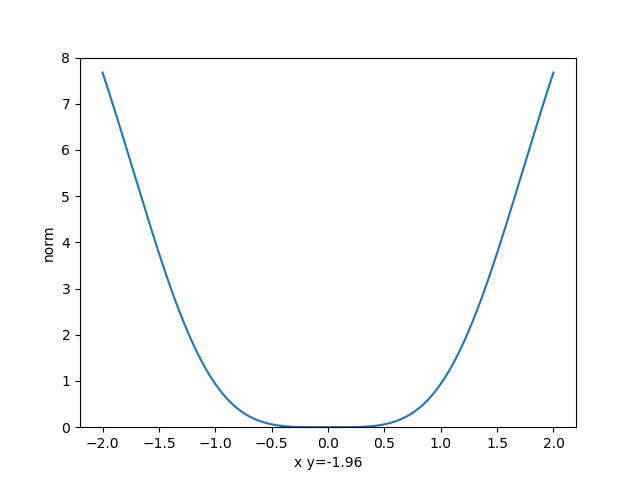

In [121]:
plt.figure()

idx =10

t = 'x'
tp = 'y' if t == 'x' else 'x'
if t == 'x':
    plt.plot(g[0,:,idx],norm[idx,:])
    c = g[1,0,idx]
else:
    plt.plot(g[1,idx],norm[:,idx])
    c = g[0,idx,0]
plt.xlabel('{} {}={:.2f}'.format(t, tp, c))
plt.ylabel('norm')
plt.ylim(0,norm.max())
#plt.plot(g[1,0],norm[:,0])
pass

<IPython.core.display.Javascript object>


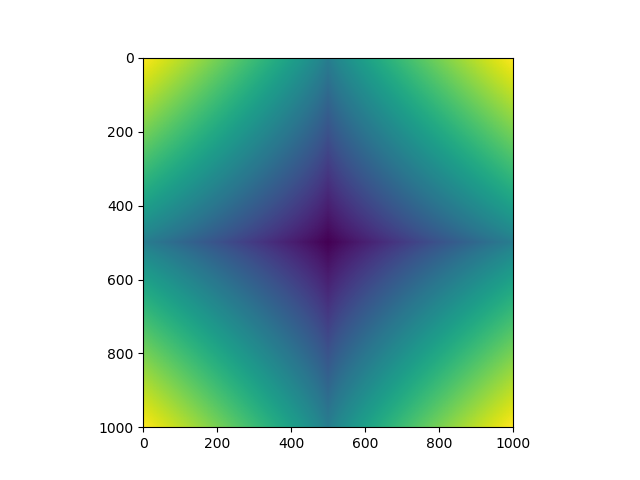

In [106]:
norm = lnorm(g, p=0.8)
plt.figure()
plt.imshow(norm)
#plt.plot(x.reshape(-1),y.reshape(-1), ls='', marker='.')
pass

In [ ]:
x, y = g[:,np.isclose(norm, 1, atol=5e-1)]
plt.figure(figsize=(4,4))
plt.plot(x,y,ls='',marker='.')
plt.xlim(-1,1)
plt.ylim(-1,1)